In [1]:
using POMDPs, POMDPGym, Crux, Flux, Colors
using Distributions, Measures, BSON, Printf, Zygote

┌ Warning: You are using Matplotlib 3.3.4, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /home/smkatz/.julia/packages/Plots/Xv2qA/src/backends/pyplot.jl:29


In [2]:
using GridInterpolations

In [3]:
using PGFPlots

In [4]:
resetPGFPlotsPreamble()
include("/home/smkatz/Documents/Util/support_code.jl");

# Example Perception Inputs

In [6]:
obsfn(s) = POMDPGym.simple_render_pendulum(s, dt=0.05, noise=Normal(0, 0.1))

obsfn (generic function with 1 method)

In [59]:
im = Float64.(obsfn([0.0, 0.0])[:, :, 1]);

In [60]:
ax = Axis(Plots.MatrixPlot(reverse(im, dims=1)), axisEqualImage=true, style="xticklabels = {,}, yticklabels = {,}");

In [65]:
#tikzCode(ax)

In [66]:
#new_tikz = "\\begin{axis}[\n  axis equal image = {true},\n  xticklabels = {,}, yticklabels = {,},\n  enlargelimits = false,\n  axis on top,\n  colormap={wb}{gray(0cm)=(0); gray(1cm)=(1)},\n  xmin = 0.5,\n  xmax = 10.5,\n  ymin = 0.5,\n  ymax = 18.5\n]\n\n\\addplot[\n  point meta min = 0.0,\n  point meta max = 1.0,\n  point meta = explicit,\n  matrix plot*,\n  mesh/cols = 10,\n  mesh/rows = 18\n] table[\n  meta = data\n] {tmp_10000000000020.dat};\n\n\\end{axis}"

In [63]:
ax = PGFPlots.TikzPicture(new_tikz, options=pgfplotsoptions(), preamble=pgfplotspreamble());

In [64]:
PGFPlots.save("pend_ex_1.pdf", ax)

# Solving for Risk Function

In [5]:
include("../src/risk_solvers.jl")
include("../inverted_pendulum/controllers/rule_based.jl")
include("problem_setup.jl");

In [6]:
# Setup
env = InvertedPendulumMDP(λcost=0.1f0, failure_thresh=π / 4)
simple_policy = FunPolicy(continuous_rule(0.0, 2.0, -1))
rmdp, px, θs, ωs, s_grid, 𝒮, s2pt, cost_points, ϵ1s, ϵ2s, ϵ_grid = rmdp_pendulum_setup(env, simple_policy);

In [7]:
# Solve for distribution over costs
@time Uw, Qw = solve_cvar_fixed_particle(rmdp, px, s_grid, 𝒮, s2pt, cost_points);

 49.887164 seconds (543.01 M allocations: 25.645 GiB, 9.92% gc time, 4.27% compilation time)


In [8]:
# Create CVaR convenience function
CVaR(s, ϵ, α) = CVaR(s2pt([0.0, s...]), ϵ, s_grid, ϵ_grid, Qw, cost_points; α)

CVaR (generic function with 2 methods)

# Pendulum CVaR

### Varying alpha

In [91]:
get_heat(x, y, α) = CVaR([x, y], [0.0, 0.0], α)
ax1 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.0), (-π / 4, π / 4), (-2, 2),
    (colormap = pasteljet), colorbar=false))
ax1.xlabel = L"$\theta$ (rad)"
ax1.ylabel = L"$\omega$ (rad/s)"
ax1.height = "4cm"
ax1.width = "4cm"
ax1.title = L"$\alpha=0.0$"

ax2 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.5), (-π / 4, π / 4), (-2, 2),
    (colormap = pasteljet), colorbar=false))
ax2.xlabel = L"$\theta$ (rad)"
#ax2.ylabel = L"$\omega$ (rad/s)"
ax2.height = "4cm"
ax2.width = "4cm"
ax2.style = "yticklabels = {,}"
ax2.title = L"$\alpha=0.5$"

ax3 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.9), (-π / 4, π / 4), (-2, 2),
    (colormap = pasteljet)))
ax3.xlabel = L"$\theta$ (rad)"
#ax3.ylabel = L"$\omega$ (rad/s)"
ax3.height = "4cm"
ax3.width = "4cm"
ax3.style = "yticklabels = {,}"
ax3.title = L"$\alpha=0.9$"

g = GroupPlot(3, 1, groupStyle="horizontal sep = 0.75cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
push!(g, ax3)
#PGFPlots.save("pendulum_risk_alpha.tex", g, include_preamble=false);
g

In [96]:
maximum([get_heat(x, y, 0.0) for x in collect(0:0.1:π/4) for y in collect(0:0.1:2)])

0.7853981633974422

### Error Slice

In [105]:
get_heat(x, y, α) = CVaR([0.2, 0.0], [x, y], α)
ax1 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.0), (-0.4, 0.4), (-1, 1),
    (colormap = pasteljet)))
ax1.xlabel = L"$\epsilon_\theta$"
ax1.ylabel = L"$\epsilon_\omega$"
ax1.height = "4cm"
ax1.width = "4cm"
ax1
PGFPlots.save("pend_risk_slice.tex", ax1, include_preamble=false)

In [107]:
minimum([get_heat(x, y, 0.0) for x in collect(-0.4:0.1:0.4) for y in collect(-1:0.1:1)])

0.1598531716076556

### Error Slice Varying Alpha

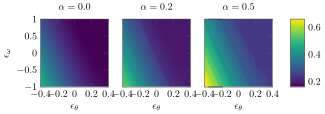

In [22]:
get_heat(x, y, α) = CVaR([0.2, 0.0], [x, y], α)
ax1 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.0), (-0.4, 0.4), (-1, 1),
    (colormap = pasteljet), colorbar=false, zmin=0.159, zmax=0.66))
ax1.xlabel = L"$\epsilon_\theta$"
ax1.ylabel = L"$\epsilon_\omega$"
ax1.height = "4cm"
ax1.width = "4cm"
ax1.title = L"$\alpha=0.0$"

ax2 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.2), (-0.4, 0.4), (-1, 1),
    (colormap = pasteljet), zmin=0.159, zmax=0.66))
ax2.xlabel = L"$\epsilon_\theta$"
#ax2.ylabel = L"$\epsilon_\omega$"
ax2.height = "4cm"
ax2.width = "4cm"
ax2.style = "yticklabels = {,}"
ax2.title = L"$\alpha=0.2$"

ax3 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.5), (-0.4, 0.4), (-1, 1),
    (colormap = pasteljet), zmin=0.159, zmax=0.66))
ax3.xlabel = L"$\epsilon_\theta$"
#ax3.ylabel = L"$\epsilon_\omega$"
ax3.height = "4cm"
ax3.width = "4cm"
ax3.style = "yticklabels = {,}"
ax3.title = L"$\alpha=0.5$"

g = GroupPlot(3, 1, groupStyle="horizontal sep = 0.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
push!(g, ax3)
#PGFPlots.save("pend_cvar_slices_alpha.tex", g, include_preamble=false)
g

In [17]:
minimum([get_heat(x, y, 0.0) for x in collect(-0.4:0.1:0.4) for y in collect(-1:0.1:1)])

0.1598531716076556

# Pendulum Risk Weights

In [9]:
# Convenience functions
riskmin(x; α) = minimum([CVaR(x, [ϵ1, ϵ2], α)[1] for ϵ1 in ϵ1s, ϵ2 in ϵ2s])
riskmax(x; α) = maximum([CVaR(x, [ϵ1, ϵ2], α)[1] for ϵ1 in ϵ1s, ϵ2 in ϵ2s])
#risk_weight(x; α) = riskmax(x; α) - riskmin(x; α)
risk_weight(x; α) = riskmax(x; α) - CVaR(x, [0.0, 0.0], α)[1]

risk_weight (generic function with 1 method)

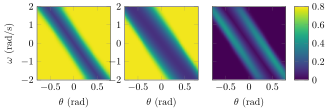

In [25]:
ax1 = Axis(Plots.Image((x, y) -> riskmax([x, y], α=0.0), (-π / 4, π / 4), (-2, 2),
    colormap=pasteljet, zmin=0.0, zmax=0.8, colorbar=false))
ax1.xlabel = L"$\theta$ (rad)"
ax1.ylabel = L"$\omega$ (rad/s)"
ax1.height = "4.2cm"
ax1.width = "4.2cm"

ax2 = Axis(Plots.Image((x, y) -> CVaR([x, y], [0.0, 0.0], 0.0), (-π / 4, π / 4), (-2, 2),
    colormap=pasteljet, zmin=0.0, zmax=0.8, colorbar=false))
ax2.xlabel = L"$\theta$ (rad)"
#ax2.ylabel = L"$\omega$ (rad/s)"
ax2.height = "4.2cm"
ax2.width = "4.2cm"
ax3.style = "yticklabels = {,}"

ax3 = Axis(Plots.Image((x, y) -> risk_weight([x, y], α=0.0), (-π / 4, π / 4), (-2, 2),
    colormap=pasteljet, zmin=0.0, zmax=0.8))
ax3.xlabel = L"$\theta$ (rad)"
#ax3.ylabel = L"$\omega$ (rad/s)"
ax3.height = "4.2cm"
ax3.width = "4.2cm"
ax3.style = "yticklabels = {,}"

g = GroupPlot(3, 1, groupStyle="horizontal sep = 0.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
push!(g, ax3)
#PGFPlots.save("pend_rw.tex", g, include_preamble=false)
g

# Returns

In [27]:
data_baseline = [500.0, 58.150001525878906, 28.450000762939453, 235.10000610351562, 34.66999816894531]
data_risk = [259.1099853515625, 267.010009765625, 500.0, 375.5299987792969, 500.0]

println("baseline mean: ", mean(data_baseline))
println("baseline standard dev: ", std(data_baseline))
println("risk mean: ", mean(data_risk))
println("risk standard dev: ", std(data_risk))

baseline mean: 171.27400131225585
baseline standard dev: 202.47896757208244
risk mean: 380.3299987792969
risk standard dev: 118.53329695680976


In [32]:
data_baseline = [495.4700012207031, 500.0, 275.5899963378906, 273.7099914550781, 164.00999450683594, 500.0, 42.90999984741211, 247.0, 385.1000061035156, 500.0, 23.450000762939453, 292.3900146484375, 500.0, 500.0, 490.8800048828125, 289.7300109863281, 500.0, 346.3699951171875, 46.31999969482422, 313.19000244140625]
data_risk = [348.8900146484375, 357.9200134277344, 496.04998779296875, 500.0, 500.0, 263.7099914550781, 371.7300109863281, 500.0, 22.950000762939453, 500.0, 500.0, 91.16999816894531, 193.85000610351562, 500.0, 492.0899963378906, 164.75, 495.57000732421875, 500.0, 500.0, 500.0]

println("baseline mean: ", mean(data_baseline))
println("baseline standard dev: ", std(data_baseline))
println("risk mean: ", mean(data_risk))
println("risk standard dev: ", std(data_risk))

baseline mean: 334.30600090026854
baseline standard dev: 167.07282041721544
risk mean: 389.9340013504028
risk standard dev: 157.9396080991825


In [33]:
data_baseline = [27.760000228881836, 19.56999969482422, 257.6600036621094, 372.42999267578125, 64.83999633789062]
data_risk = [500.0, 500.0, 500.0, 500.0, 500.0]
println("baseline mean: ", mean(data_baseline))
println("baseline standard dev: ", std(data_baseline))
println("risk mean: ", mean(data_risk))
println("risk standard dev: ", std(data_risk))

baseline mean: 148.45199851989747
baseline standard dev: 158.31979127287207
risk mean: 500.0
risk standard dev: 0.0


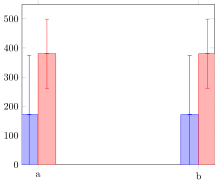

In [31]:
ax = Axis(Plots.BarChart(["a", "b"], [mean(data_baseline), mean(data_baseline)], errorBars=ErrorBars(y=[std(data_baseline), std(data_baseline)])))
push!(ax, Plots.BarChart(["a", "b"], [mean(data_risk), mean(data_risk)], errorBars=ErrorBars(y=[std(data_risk), std(data_risk)])))
ax